In [1]:
"""
QPSK Transmitter + Receiver Simulation

1. Generate bits
2. QPSK modulation
3. Pulse filtering
4. Channel
5. Matched filter
6. Symbol timing synchronization
7. Carrier frequency and phase recovery
8. Demodulation
9. Analysis

TODO: 
- Add multipath effects to channel & equalizer
- Framing? Detect start of frame


Framing: 
1. Initial coarse CFO guess by examining phase drift of first correlation peak's preamble
2. Correct this CFO
3. Run frame detector on corrected symbols. Have this at 2+ SPS to make robust to fractional STO
4. On frame detection: Run data aided Costas, Gardner, etc. on preamble and decision-directed on payload. Coherently demodulate corrected payload
    - Occasionally update coarse CFO guess using phase drift of preamble correlation.



Date created: 6/9/25
Author: Cole Delong
"""

"\nQPSK Transmitter + Receiver Simulation\n\n1. Generate bits\n2. QPSK modulation\n3. Pulse filtering\n4. Channel\n5. Matched filter\n6. Symbol timing synchronization\n7. Carrier frequency and phase recovery\n8. Demodulation\n9. Analysis\n\nTODO: \n- Add multipath effects to channel & equalizer\n- Framing? Detect start of frame\n\n\nFraming: \n1. Initial coarse CFO guess by examining phase drift of first correlation peak's preamble\n2. Correct this CFO\n3. Run frame detector on corrected symbols. Have this at 2+ SPS to make robust to fractional STO\n4. On frame detection: Run data aided Costas, Gardner, etc. on preamble and decision-directed on payload. Coherently demodulate corrected payload\n    - Occasionally update coarse CFO guess using phase drift of preamble correlation.\n\n\n\nDate created: 6/9/25\nAuthor: Cole Delong\n"

In [2]:
# Reload imports every time this cell is run
%reload_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib.pyplot as plt

# Custom Utils
import py_sdrlib as cu                      # C++ utils

import py_utils as pu                       # Python utils
from py_utils import visualization as vz    # Python visualization utils

# Constants
SPS = int(2)                        # samples per symbol
N_BITS = 10**4                      # number of bits to simulate
N_SYMBOLS = int(N_BITS/2)           # qpsk: 2 bits/sample, IF differential coding: +1 symbol
N_RRC_TAPS = SPS*10 + 1             # number of taps in rrc filter (10 on each side of center)
SNR_DB = 20                         # channel SNR in dB  


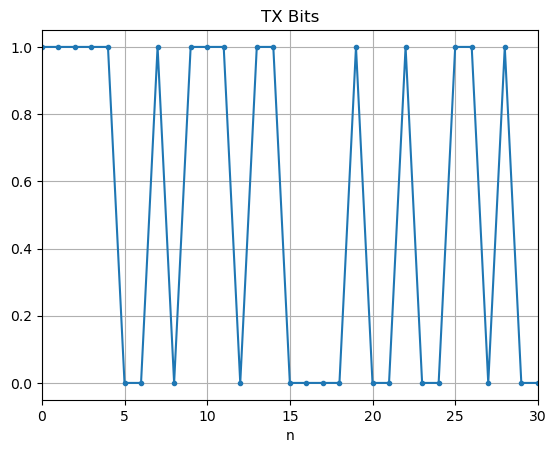

In [3]:
### Generate bits ###
bits_tx = np.random.randint(2, size=N_BITS)
vz.plot_signal(bits_tx, title='TX Bits', xlim=[0, 30]);

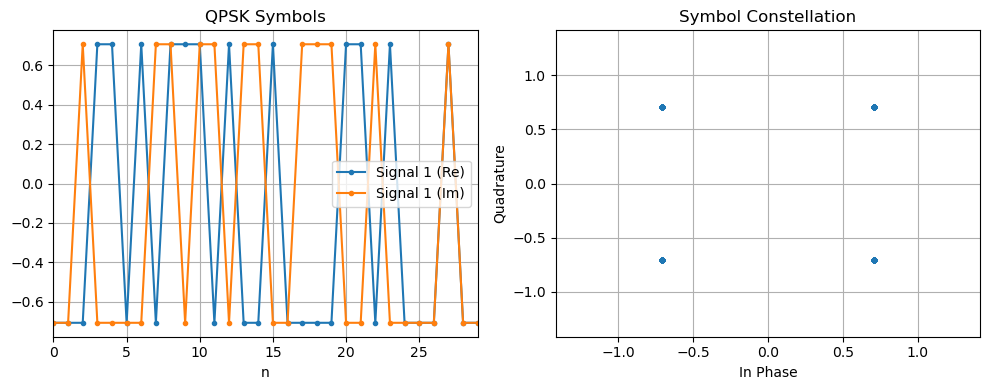

In [4]:
### QPSK modulation ###

# Use differential coding to account for phase ambiguity
# sym_tx = pu.coding.diff_encode_psk_symbols(pu.modulation.modulate_qpsk(bits_tx))
sym_tx = pu.modulation.modulate_qpsk(bits_tx)

fig, ax = vz.visualize(
    sym_tx, 
    plots=('time', 'constellation'), 
    plot_kwargs={
        'time': {'title': 'QPSK Symbols', 'n_samps': 30}, 
        'constellation': {'title': 'Symbol Constellation'}
    }
);

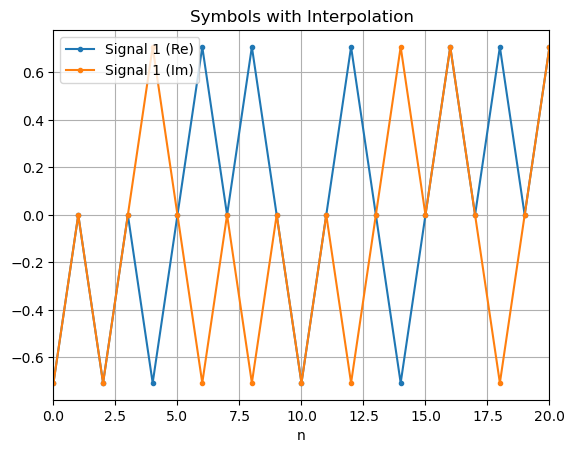

In [5]:
### Pulse filtering ###

# Upsample by factor of SPS
sym_upsamp = pu.dsp.upsample(sym_tx, SPS)

vz.plot_signal(sym_upsamp, title='Symbols with Interpolation', xlim=[0, 10*SPS]);

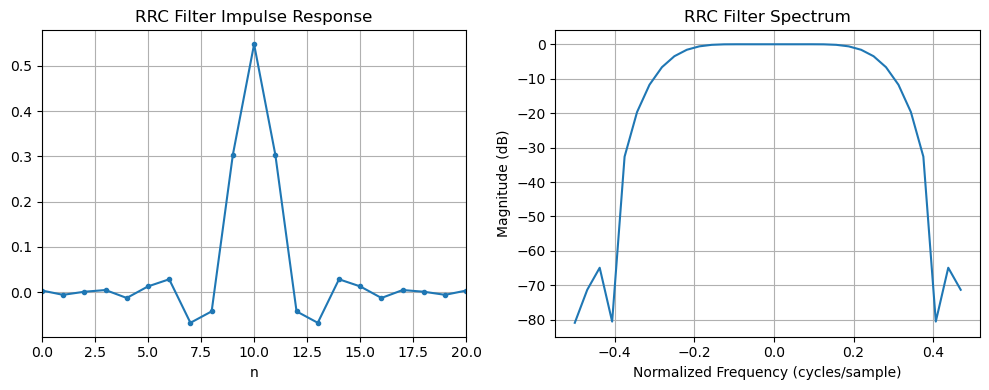

In [6]:
h_rrc = pu.dsp.rrc(Ts=SPS, n_taps=N_RRC_TAPS)

fig, ax = vz.visualize(
    h_rrc.real, 
    plots=('time', 'frequency'), 
    plot_kwargs={
        'time': {'title': 'RRC Filter Impulse Response'}, 
        'frequency': {'title': 'RRC Filter Spectrum'}
    }
);


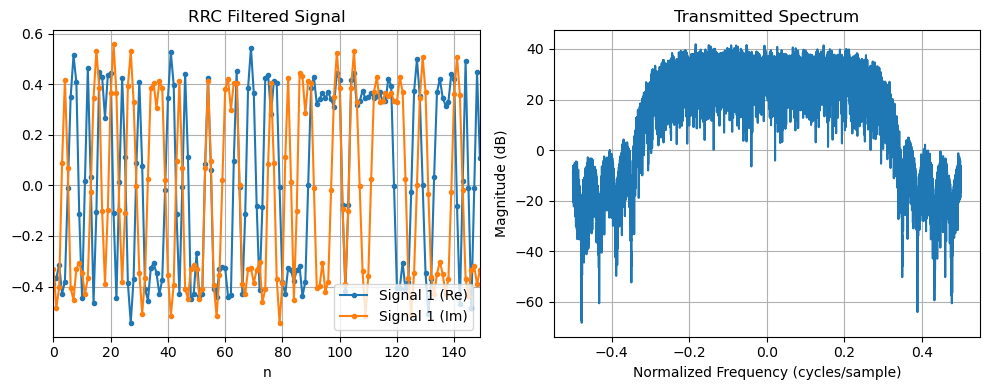

In [7]:
# Convolve signal with RRC filter
sig_tx = pu.rrc_filter(sym_upsamp, n_taps=N_RRC_TAPS, Ts=SPS).astype(np.complex64)

fig, ax = vz.visualize(
    sig_tx, 
    plots=('time', 'frequency'), 
    plot_kwargs={
        'time': {'title': 'RRC Filtered Signal', 'n_samps': 150}, 
        'frequency': {'title': 'Transmitted Spectrum'}
    }
);

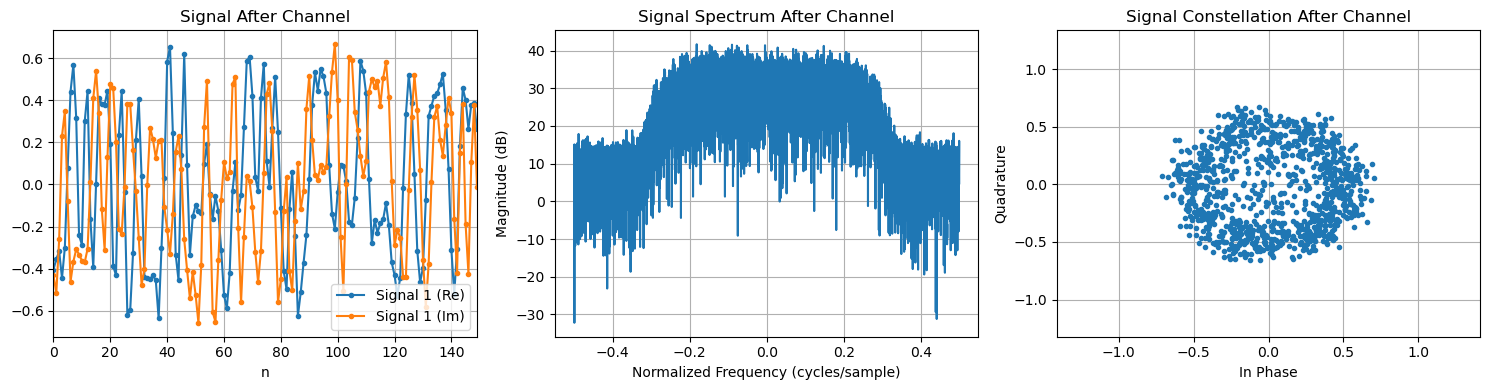

In [ ]:
### Channel ###

# Apply CFO
# testing/realistic: 1-5%, aggressive: 10%
sig_chan = np.empty_like(sig_tx).astype(np.complex64)

# sig_chan = pu.channel.apply_cfo(sig_tx, 0.01)?
cu.channel.apply_cfo(sig_tx, sig_chan, 0.01) # --- IGNORE ---

# Apply STO
mu = 0.3
sig_chan = pu.channel.apply_sto(sig_chan, mu)

# AWGN
sig_chan = pu.channel.apply_awgn(sig_chan, SNR_DB)
sig_rx = sig_chan

fig, ax = vz.visualize(
    sig_rx, 
    plots=('time', 'frequency', 'constellation'), 
    plot_kwargs={
        'time': {'title': 'Signal After Channel', 'xlim': [500, 520]}, 
        'frequency': {'title': 'Signal Spectrum After Channel'},
        'constellation': {'title': 'Signal Constellation After Channel'}
    }
);

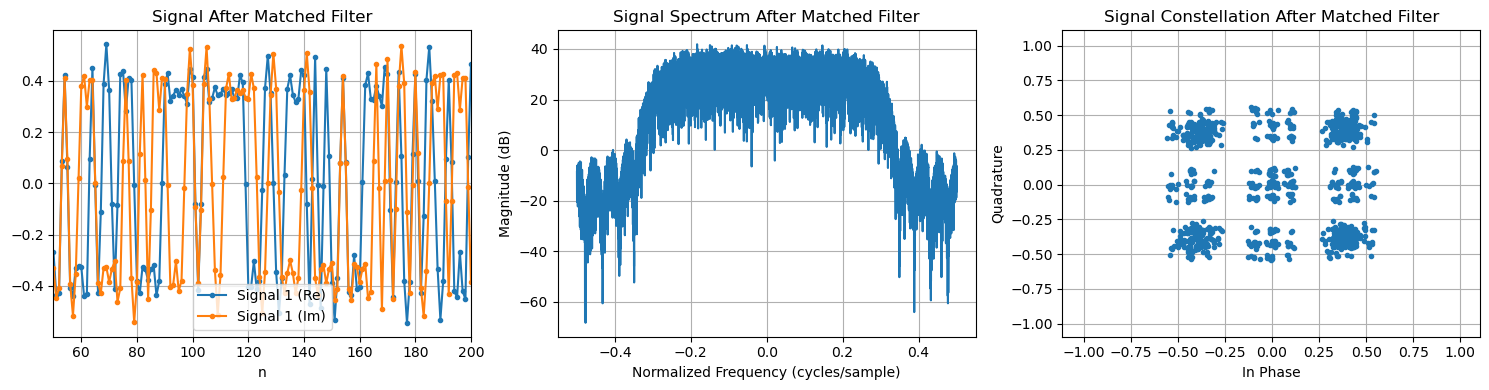

In [ ]:
### Matched filter ###
# sig_matched = np.convolve(sig_rx, h_rrc)
sig_matched = pu.dsp.rrc_filter(sym_upsamp, n_taps=N_RRC_TAPS, Ts=SPS)

fig, ax = vz.visualize(
    sig_matched, 
    plots=('time', 'frequency', 'constellation'), 
    plot_kwargs={
        'time': {'title': 'Signal After Matched Filter', 'xlim': [50, 200]}, 
        'frequency': {'title': 'Signal Spectrum After Matched Filter'},
        'constellation': {'title': 'Signal Constellation After Matched Filter'}
    }
);

4950


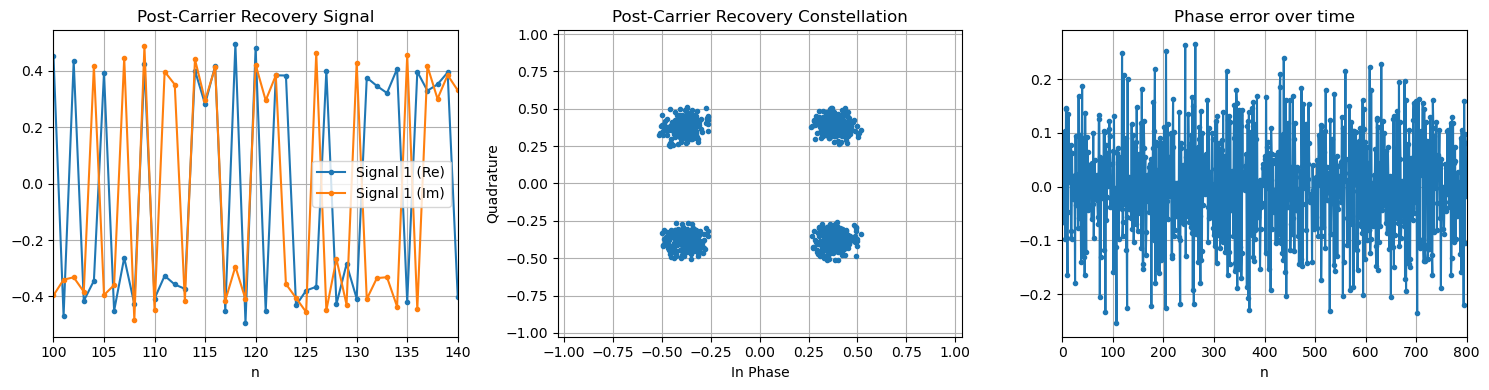

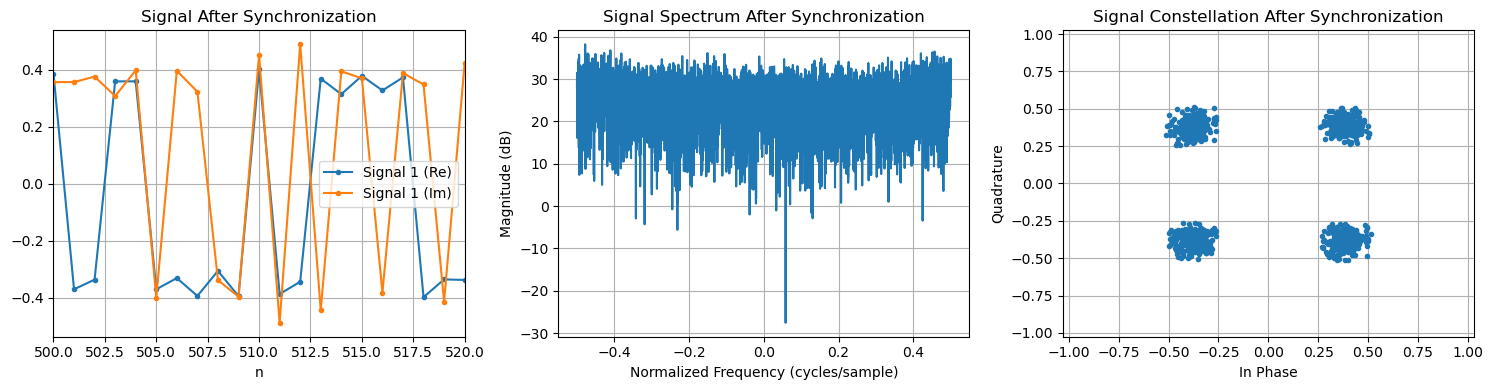

In [15]:

### Symbol Synchronization ###

"""
Gardner: 
- Low complexity
- 2x oversampling fine since sample rate is same for both rx and tx on PlutoSDR
- Better than M&M in lower SNR environments
- Real-time low-latency

cubic interpolation:
- Complexity not bad (better than sinc) when using Farrow structures
- More accurate than lower order quadratic interpolaters
"""
stc = pu.timing_recovery.GardnerSymbolTimingCorrector()
symbols_sampled = stc.correct_batch(sig_matched)
# symbols_sampled = sig_matched[::SPS]
print(len(symbols_sampled))

### Carrier Recovery ###
# 2nd Order Costas Loop
K_p = 0.04
K_i = 0.03

control = pu.PIDFeedback(K_p, K_i)
error_history = np.empty_like(symbols_sampled, dtype=np.float32)
sym_rot = pu.carrier_recovery.costas_loop(symbols_sampled, control, error_history=error_history)
symbols = np.array([sym_rot[i]*(i % SPS == 0) for i in np.arange(sym_rot.size)], dtype=sym_rot.dtype)


# Add in before + after plots for (carrier recovery), (symbol timing recovery) 
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
vz.plot_signal(sym_rot, title='Post-Carrier Recovery Signal', xlim=[50*SPS, 70*SPS], ax=axs[0])
vz.plot_constellation(sym_rot, title='Post-Carrier Recovery Constellation', offset=50*SPS, ax=axs[1])
vz.plot_signal(error_history, title='Phase error over time', xlim=[0, 800], ax=axs[2])

plt.tight_layout()
plt.show()

fig, ax = vz.visualize(
    sym_rot, 
    plots=('time', 'frequency', 'constellation'), 
    plot_kwargs={
        'time': {'title': 'Signal After Synchronization', 'xlim': [500, 520]}, 
        'frequency': {'title': 'Signal Spectrum After Synchronization'},
        'constellation': {'title': 'Signal Constellation After Synchronization'}
    }
);

In [11]:
### Demodulation ###

# Make optimum decision for AWGN channel
# bits_rx = pu.modulation.demodulate_qpsk(pu.coding.diff_decode_psk_symbols(pu.modulation.optimum_decider_qpsk(sym_rot)))
bits_rx = pu.modulation.demodulate_qpsk(pu.modulation.optimum_decider_qpsk(sym_rot))

print(f"BER: {np.mean(bits_tx != bits_rx)}")

ValueError: operands could not be broadcast together with shapes (10000,) (9900,) 

In [ ]:
print(bits_tx[0:15])
print(bits_rx[0:15])
locs = []
for i in range(len(bits_tx)):
    if bits_tx[i] != bits_rx[i]:
        locs.append(i)

print(np.sum(bits_rx != bits_tx))

[1 1 0 1 0 1 1 0 0 1 0 0 1 0 1]
[0 0 1 1 0 1 0 1 1 0 0 1 0 0 1]


IndexError: index 9976 is out of bounds for axis 0 with size 9976